In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator
import control

### Derive capacitor voltage

In [2]:
s,n,R_on,R,L,C,D,Dp,V_g,V,I = sp.symbols("s,n,R_on,R,L,C,D,D',V_g,V,I")

In [3]:
V = V_g * D/Dp
I = V/(R*Dp)

In [4]:
A = sp.Matrix([
    [0, -Dp/L],
    [Dp/C, -1/(R*C)]
])

In [5]:
B = sp.Matrix([
    [(V_g+V)/L, D/L],
    [-I/C, 0]
])

In [6]:
C = sp.eye(2)
E = sp.Matrix([[0, 0],[0, 0]])
I = sp.eye(2)
tf = C*(s*I-A).inv()*B+E
H = sp.Matrix(tf)

In [7]:
sp.simplify(H)

Matrix([
[    V_g*(D + (D + D')*(C*R*s + 1))/(D'*(C*L*R*s**2 + D'**2*R + L*s)), D*(C*R*s + 1)/(C*L*R*s**2 + D'**2*R + L*s)],
[V_g*(-D*L*s + D'**2*R*(D + D'))/(D'**2*(C*L*R*s**2 + D'**2*R + L*s)),        D*D'*R/(C*L*R*s**2 + D'**2*R + L*s)]])

In [8]:
sp.simplify(H[2])

V_g*(-D*L*s + D'**2*R*(D + D'))/(D'**2*(C*L*R*s**2 + D'**2*R + L*s))

### Controller Design Problem

In [9]:
system = {
    'R'  :5,
    'L'  :50e-7,
    'C'  :220e-6,
    "D"  :0.238,
    "D'" :0.762,
    "V_g" :48
}
H0 = H[0].subs(system)
H1 = H[1].subs(system)
H2 = H[2].subs(system)
H3 = H[3].subs(system)

In [10]:
H2

-9.83735300803935e-5*s/(5.5e-9*s**2 + 5.0e-6*s + 2.90322) + 240.0/(5.5e-9*s**2 + 5.0e-6*s + 2.90322)

In [11]:
s  = control.TransferFunction.s

In [12]:
P =  -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)
P.dcgain()
P.zero()
P.pole()

array(82.666832)

array([ 2.43976822e+06    +0.j        , -4.54545455e+02+22970.66760562j,
       -4.54545455e+02-22970.66760562j])

array([-454.54581856+22970.66761254j, -454.54581856-22970.66761254j,
       -454.54509053+22970.6675987j , -454.54509053-22970.6675987j ])

In [13]:
gm, pm, wg, wp = control.margin(P)
round(20*np.log10(gm),2), round(pm,4), f'{round(wg)} Hz', f'{round(wp)} Hz'

(-25.88, -4.6817, '52401 Hz', '210537 Hz')

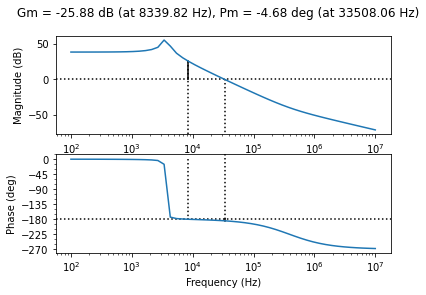

In [14]:
x,y,z = control.bode_plot(P,plot=True,dB=True,deg=True,Hz=True,margins=True)

In [15]:
s = sp.symbols("s")
P =  -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)

In [16]:
f = np.logspace(0, 7, 10000)
w = 2*np.pi*f

In [17]:
P = lambdify(s,P,modules='numpy')
P = P(1j*w)

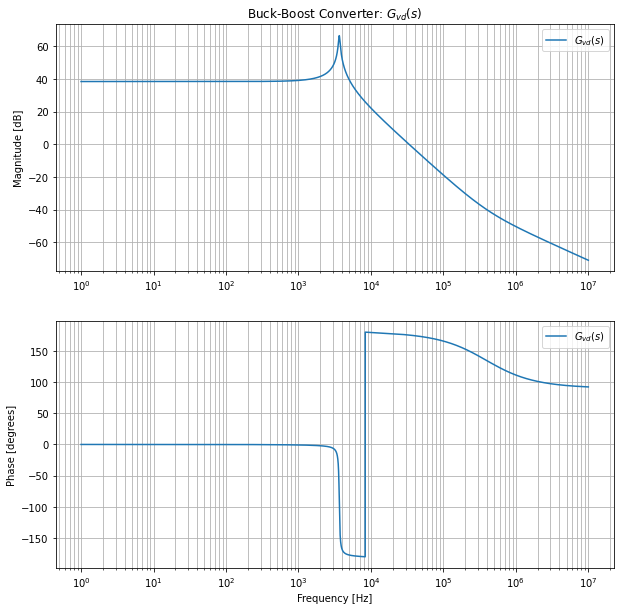

In [18]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].set_title('Buck-Boost Converter: $G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(abs(P)),label='$G_{vd}(s)$')
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(P,deg=True),label='$G_{vd}(s)$')
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();

In [19]:
C = 1/s
p = -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)

In [20]:
L = lambdify(s,C*p,modules='numpy')
L = L(1j*w)

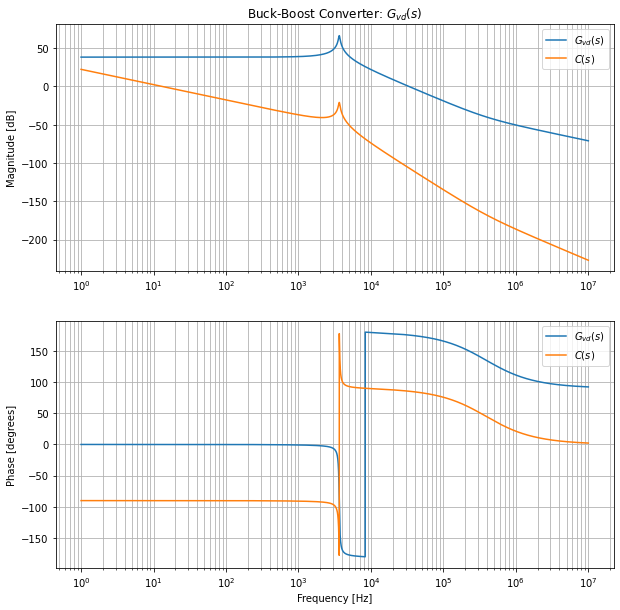

In [21]:
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].set_title('Buck-Boost Converter: $G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(abs(P)),label='$G_{vd}(s)$')
ax[0].semilogx(f,20*np.log10(abs(L)),label='$C(s)$')
ax[0].set_ylabel('Magnitude [dB]')
ax[0].grid(which='both', axis='both')
ax[0].legend()

ax[1].semilogx(f,np.angle(P,deg=True),label='$G_{vd}(s)$')
ax[1].semilogx(f,np.angle(L,deg=True),label='$C(s)$')
ax[1].set_ylabel('Phase [degrees]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(which='both', axis='both')
ax[1].legend()
plt.show();

In [22]:
s  = control.TransferFunction.s

In [47]:
L = None
Ki = 12
C = Ki/s
p = -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)
L = C*p

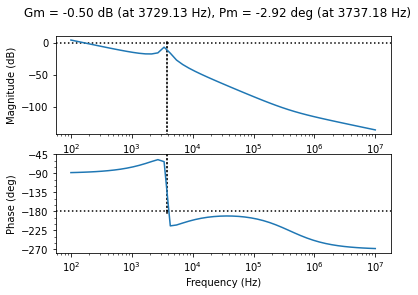

In [51]:
x,y,z = control.bode_plot(L,plot=True,dB=True,deg=True,Hz=True,margins=True)

In [58]:
L = None
wc = 2*np.pi*4000
Kp = Ki/(wc)
C = Kp+Ki/s
p = -9.837e-5*s/(5.5e-9*s**2 + 5e-6*s + 2.90322) + 240/(5.5e-9*s**2 + 5e-6*s + 2.90322)
L = C*p

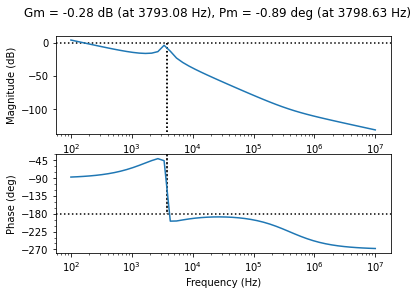

In [59]:
x,y,z = control.bode_plot(L,plot=True,dB=True,deg=True,Hz=True,mtamargins=True)

In [27]:
C

TransferFunction(array([4.16124837e-01, 1.60000000e+03]), array([1, 0]))